# Set up dependencies and import keys

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import json
import scipy.stats as st
from scipy.stats import linregress
from census import Census
from pandas.plotting import register_matplotlib_converters

# Import gmaps and Census API key
from config import (g_key,c_key)
c = Census(c_key, year=2018)

# Configure gmaps
gmaps.configure(api_key=g_key)

# Read and store dataset to DataFrames

# Import US Country level convid-19 history data

In [2]:
# Import datasets

# Import US country level data
us_history_data = pd.read_csv("Resources/us_daily.csv")

us_history_data = us_history_data.drop(columns = ["hash","dateChecked","fips","posNeg"])

us_history_data.head()


,date,states,positive,negative,pending,hospitalized,death,total,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200328,56,118234,617470,65712,16729.0,1965.0,801416,735704,435.0,3011.0,90250.0,18821.0,109071.0
1,20200327,56,99413,527220,60094,13718.0,1530.0,686727,626633,367.0,3587.0,88617.0,18678.0,107295.0
2,20200326,56,80735,438603,60251,10131.0,1163.0,579589,519338,263.0,3995.0,80999.0,16807.0,97806.0
3,20200325,56,63928,357604,51235,6136.0,900.0,472767,421532,225.0,1668.0,64846.0,11974.0,76820.0
4,20200324,56,51954,292758,14433,4468.0,675.0,359145,344712,204.0,1143.0,55437.0,9802.0,65239.0


# Import and clean states level convid-19 history data and obtain top10 states data

In [3]:
# Import states dataset
states_history_data = pd.read_csv("Resources/states_daily.csv")

states_history_data = states_history_data.drop(columns = ["hash","dateChecked","fips"])

# Filled NaN with zeor value. There are two columns have NaN values: pending and hospitalized. 
    # For pending (tests pending results), we deemed the information not relevant for our analysis as very few data points have valid value. 
    # For hospitalized, some states data are not available, we will replace them with "0" and exclude them from our analysis.
states_data_clean = states_history_data.fillna(0)
states_data_clean = states_data_clean.rename(columns = {"state":"state code"})

states_data_clean.head()    



,date,state code,positive,negative,pending,hospitalized,death,total,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200328,AK,85.0,2836.0,0.0,5.0,2.0,2921,2921,1.0,2.0,517.0,16.0,533.0
1,20200328,AL,696.0,4184.0,0.0,0.0,3.0,4880,4880,0.0,0.0,0.0,109.0,109.0
2,20200328,AR,404.0,2938.0,0.0,48.0,5.0,3342,3342,2.0,0.0,1393.0,23.0,1416.0
3,20200328,AS,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
4,20200328,AZ,873.0,7455.0,21.0,0.0,15.0,8349,8328,2.0,0.0,0.0,137.0,137.0


In [4]:
# Add state names to convid-19 data details in order

# Import data file with state name and state abbreviation
state_abb = pd.read_csv("Resources/states_abbreviation.csv")
state_abb = state_abb.rename(columns = {"State":"state", "Abbreviation":"state code"})

# Merge the states convid-19 data file with states abbreviation file and clean the output df
states_data_clean = pd.merge(states_data_clean, state_abb, on = "state code", how = "left")

states_data_clean.head()

,date,state code,positive,negative,pending,hospitalized,death,total,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,state
0,20200328,AK,85.0,2836.0,0.0,5.0,2.0,2921,2921,1.0,2.0,517.0,16.0,533.0,Alaska
1,20200328,AL,696.0,4184.0,0.0,0.0,3.0,4880,4880,0.0,0.0,0.0,109.0,109.0,Alabama
2,20200328,AR,404.0,2938.0,0.0,48.0,5.0,3342,3342,2.0,0.0,1393.0,23.0,1416.0,Arkansas
3,20200328,AS,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,American Samoa
4,20200328,AZ,873.0,7455.0,21.0,0.0,15.0,8349,8328,2.0,0.0,0.0,137.0,137.0,Arizona


In [5]:
# Obtain states data as of 3-28, the cutoff date.
states_328 = states_data_clean.loc[states_data_clean["date"] == 20200328]
states_328_clean = states_328.drop(columns = ["deathIncrease","hospitalizedIncrease","negativeIncrease",
                                     "positiveIncrease","totalTestResultsIncrease"])

# Sort states data as of 3-28 by positive cases
sorted_states328 = states_328_clean.sort_values(by=["positive"], ascending = False)
sorted_states328 = sorted_states328.reset_index(drop = True)

total_states = sorted_states328.sum()

top10_states = sorted_states328.head(10)

top10_sum = top10_states.sum()

# Sum the rest states and group as OTHERS and add to the top10 DF
rest_state = pd.DataFrame([{"date":"20200328","state":"OTHERS",
                      "positive":(total_states["positive"] - top10_sum["positive"]),
                      "negative":(total_states["negative"] - top10_sum["negative"]),
                      "pending":(total_states["pending"] - top10_sum["pending"]),
                      "hospitalized":(total_states["hospitalized"] - top10_sum["hospitalized"]),
                      "death":(total_states["death"] - top10_sum["death"]),
                      "total":(total_states["total"] - top10_sum["total"]),
                      "totalTestResults":(total_states["totalTestResults"] - top10_sum["totalTestResults"])}])

top10_states = pd.concat([top10_states,rest_state],ignore_index=True, axis = 0, sort = False)
top10_states.loc[10,"state"] = "Others"

top10_states

,date,state code,positive,negative,pending,hospitalized,death,total,totalTestResults,state
0,20200328,NY,52318.0,103616.0,0.0,10054.0,728.0,155934,155934,New York
1,20200328,NJ,11124.0,19386.0,0.0,0.0,140.0,30510,30510,New Jersey
2,20200328,CA,4643.0,20549.0,64400.0,1034.0,101.0,89592,25192,California
3,20200328,MA,4257.0,30792.0,0.0,350.0,44.0,35049,35049,Massachusetts
4,20200328,FL,3763.0,35366.0,0.0,526.0,54.0,39129,39129,Florida
5,20200328,WA,3723.0,49015.0,0.0,254.0,175.0,52738,52738,Washington
6,20200328,MI,3657.0,9109.0,0.0,0.0,92.0,12766,12766,Michigan
7,20200328,IL,3491.0,22000.0,0.0,0.0,47.0,25491,25491,Illinois
8,20200328,LA,3315.0,21846.0,0.0,927.0,137.0,25161,25161,Louisiana
9,20200328,PA,2751.0,25254.0,0.0,682.0,34.0,28005,28005,Pennsylvania


# Obtain county level convid-19 dataset

In [6]:
# Import county confirmed cases over time and death over time dataset
counties_data = pd.read_csv("Resources/counties_daily.csv")

counties_data.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


note the following for the above county level cases data. need to consider this when we do county analysis. we need to make a note for presentation
### Geographic Exceptions

* New York City

All cases for the five boroughs of New York City (New York, Kings, Queens, Bronx and Richmond counties) are assigned to a single area called New York City.

* Kansas City, Mo.

Four counties (Cass, Clay, Jackson and Platte) overlap the municipality of Kansas City, Mo. The cases and deaths that we show for these four counties are only for the portions exclusive of Kansas City. Cases and deaths for Kansas City are reported as their own line.

# Obtain state population, land area and population density dataset

There are four Insular areas that have confirmed COVID-19 cases but we did not obtain population data from Census:American Samoa(AS), Guam(GU),Northern Mariana Islands(MP),Puerto Rico(PR),U.S. Virgin Islands(VI),U.S.The total confirmed cases of these areas as of 3/28 was 179 total, less than 1% of total confirmed cases number. As such, deemed reasonable to not including in our analysis and will not impact out results.

In [7]:
# Import US States and counties population and population density data from Census

# this is 2010 census data, the population is outdated but we should use the arealand to calculated population density
states2010_area = pd.read_excel("Resources/states_2010Census.xlsx")[["STATE","NAME","AREALAND"]]

# convert land area to square miles
converter = 0.3861/1000000
states2010_area["AREALAND"] = states2010_area["AREALAND"]*converter

# update column names
states2010_area = states2010_area.rename(columns = {"STATE":"state code","NAME":"state","AREALAND":"state land area(sq mi)"})
states2010_area = states2010_area.drop(columns = ["state code"])

states2010_area.head()

,state,state land area(sq mi)
0,Alabama,50645.040894
1,Alaska,570637.734990
2,Arizona,113593.444095
3,Arkansas,52035.184030
4,California,155778.342314


In [8]:
# Run Census Search to retrieve data on all states for Census 2018 estimated population
state_population_census = c.acs5.get(("NAME", "B01003_001E"), {'for': 'state:*'})

# Convert to DataFrame
state_population = pd.DataFrame(state_population_census)

# update column names amnd clean data
state_population = state_population.rename(columns={"B01003_001E": "state population(2018)", "NAME": "state", "state": "state code"})
state_population = state_population.drop(columns = ["state code"])

state_population.head()

,state,state population(2018)
0,Minnesota,5527358.0
1,Mississippi,2988762.0
2,Missouri,6090062.0
3,Montana,1041732.0
4,Nebraska,1904760.0


In [9]:
# Merge state population dataframe and state land area dataframe
state_complete = pd.merge(states2010_area, state_population, on = "state")

# calculate population density for each state
state_complete["state population density"] = state_complete["state population(2018)"]/state_complete["state land area(sq mi)"]

state_complete.head()

,state,state land area(sq mi),state population(2018),state population density
0,Alabama,50645.040894,4864680.0,96.054419
1,Alaska,570637.734990,738516.0,1.294194
2,Arizona,113593.444095,6946685.0,61.153925
3,Arkansas,52035.184030,2990671.0,57.474016
4,California,155778.342314,39148760.0,251.310673


In [10]:
state_complete["latitude"] = ""
state_complete["longitude"] = ""

for index, row in state_complete.iterrows():

# Target state
    state = row["state"]

# Build the endpoint URL
    target_url = f'https://maps.googleapis.com/maps/api/geocode/json?address={state}&key={g_key}'

# Run a request to endpoint and convert result to json
    geo_data = requests.get(target_url).json()

    state_complete.loc[index,"latitude"] = geo_data["results"][0]["geometry"]["location"]["lat"]
    state_complete.loc[index,"longitude"] = geo_data["results"][0]["geometry"]["location"]["lng"]

In [11]:
state_complete.head()

,state,state land area(sq mi),state population(2018),state population density,latitude,longitude
0,Alabama,50645.040894,4864680.0,96.054419,32.3182,-86.9023
1,Alaska,570637.734990,738516.0,1.294194,64.2008,-149.494
2,Arizona,113593.444095,6946685.0,61.153925,34.0489,-111.094
3,Arkansas,52035.184030,2990671.0,57.474016,35.2011,-91.8318
4,California,155778.342314,39148760.0,251.310673,36.7783,-119.418


# Obtain counties population, land area and population density dataset

In [12]:
# Run Census Search to retrieve data on all states for Census 2018 estimated population
county_population_census = c.acs5.get(("NAME", "B01003_001E"), {'for': 'county:*'})

# Convert to DataFrame
county_population = pd.DataFrame(county_population_census)

county_population[['county','state']] = county_population.NAME.str.split(',',expand=True) 

# update column names amnd clean data
county_population = county_population.rename(columns={"B01003_001E": "county population(2018)"})

county_population = county_population.drop(columns = ["NAME"])

county_population = county_population.loc[:,["state","county","county population(2018)"]]

county_population = county_population.sort_values(["state","county"]).reset_index(drop = True)

In [13]:
county_population.head()

,state,county,county population(2018)
0,Alabama,Autauga County,55200.0
1,Alabama,Baldwin County,208107.0
2,Alabama,Barbour County,25782.0
3,Alabama,Bibb County,22527.0
4,Alabama,Blount County,57645.0


In [14]:
# Import census land area dataser
census2010county = pd.read_csv("Resources/county_land_area_2010.csv")
census2010county = census2010county.fillna(0)
census2010county = census2010county.loc[census2010county["Target Geo Id2"]>100]
census2010county = census2010county.reset_index(drop = True)
census2010county 

county_land_area = census2010county.loc[:,["Geographic area.1","Area in square miles - Land area"]]
county_land_area = county_land_area.rename(columns = {"Geographic area.1":"county",
                                                      "Area in square miles - Land area":"county land area(sq mi)"})


In [15]:
# Merge county population dataframe and state land area dataframe
county_complete = pd.merge(county_population, county_land_area, on = "county" )

county_complete["county population density"] = county_complete["county population(2018)"]/county_complete["county land area(sq mi)"]

In [16]:
county_complete.head()

,state,county,county population(2018),county land area(sq mi),county population density
0,Alabama,Autauga County,55200.0,594.44,92.860507
1,Alabama,Baldwin County,208107.0,1589.78,130.903018
2,Alabama,Baldwin County,208107.0,257.84,807.116817
3,Georgia,Baldwin County,45286.0,1589.78,28.485702
4,Georgia,Baldwin County,45286.0,257.84,175.636053


# Cumulative Analysis

In [17]:
# US overview

In [18]:
#Generate a summary statistics table of mean, median, variance, standard deviation, and SEM for cases confirmed and deaths by state


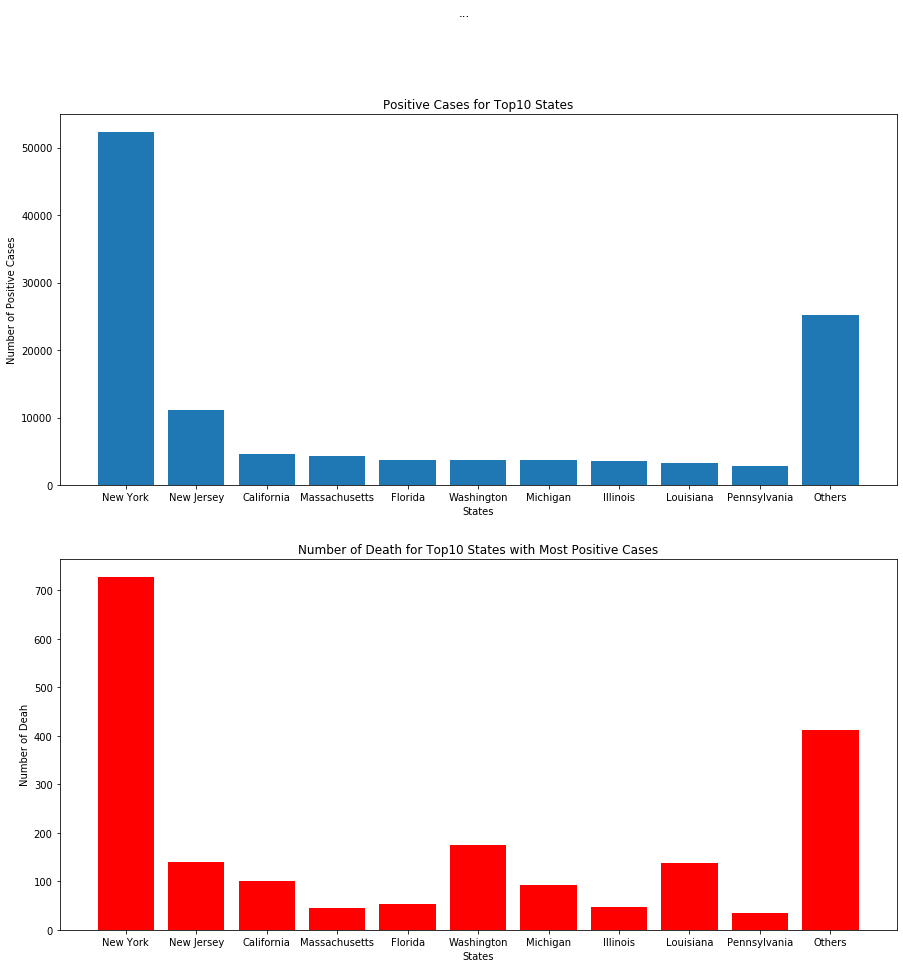

In [19]:
#Generate a bar chart showing number of cases confirmed and number of death by states

fig, (state_positive, state_death) = plt.subplots(2)
fig.suptitle('...')
states_list = top10_states["state"]
positive = top10_states["positive"]
death = top10_states["death"]
state_positive.bar(states_list, positive)
state_death.bar(states_list, death, color = "red")

state_positive.set_title("Positive Cases for Top10 States")
state_positive.set_ylabel("Number of Positive Cases")
state_positive.set_xlabel("States")

state_death.set_title("Number of Death for Top10 States with Most Positive Cases")
state_death.set_ylabel("Number of Deah")
state_death.set_xlabel("States")

fig.set_figheight(15)
fig.set_figwidth(15)

plt.savefig("Output_Figures/state_positive&death_bar.png")
plt.show()

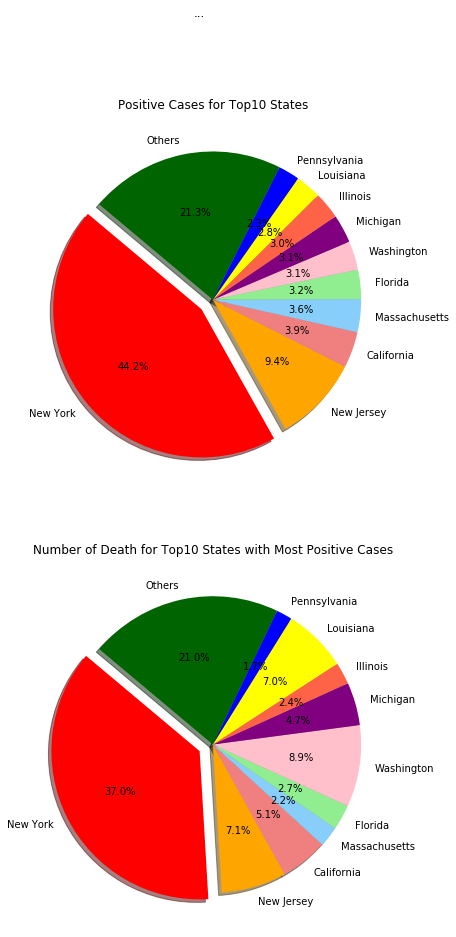

In [20]:
#Generate a pie chart showing number of positive cases and death over total cases in US (%)

fig2, (state_positive, state_death) = plt.subplots(2)
fig2.suptitle('...')
states_list = top10_states["state"]
positive = top10_states["positive"]
death = top10_states["death"]

explode = (0.1,0,0,0,0,0,0,0,0,0,0)
colors = ["red", "orange", "lightcoral", "lightskyblue","lightgreen","pink",
          "purple","tomato","yellow","blue","darkgreen"]
state_positive.pie(positive, explode=explode, labels=states_list, colors = colors,
        autopct="%1.1f%%", shadow=True, startangle=140)
state_death.pie(death, explode=explode, labels=states_list, colors = colors,
        autopct="%1.1f%%", shadow=True, startangle=140)

state_positive.set_title("Positive Cases for Top10 States")
state_death.set_title("Number of Death for Top10 States with Most Positive Cases")

fig2.set_figheight(15)
fig2.set_figwidth(15)

plt.savefig("Output_Figures/state_positive&death_pie.png")
plt.show()

In [21]:
#Generate a bar chart showing # of positive cases over $1M population by state (top 10 states)

# Merge top10 states covid-19 data with states geo data

top10_states_updated = pd.merge(top10_states, state_complete, on = "state")

# Calculate % of positive cases over population
top10_states_positive = top10_states_updated["positive"]
top10_states_population = top10_states_updated["state population(2018)"]

top10_states_updated["positive in 1M"] = top10_states_positive/top10_states_population *1000000

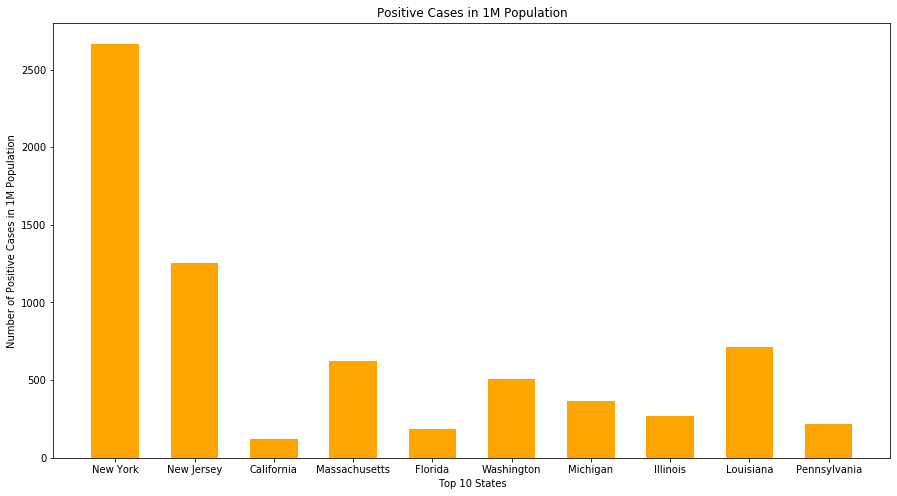

In [22]:
# Create bar chart
top10_states = top10_states_updated["state"]
top10_positive1M = top10_states_updated["positive in 1M"]

plt.figure(figsize = (15,8))
plt.bar(top10_states, top10_positive1M, color = "orange", width = 0.6)

# Set the xlabel and ylabel using class methods
plt.xlabel("Top 10 States")
plt.ylabel("Number of Positive Cases in 1M Population")
plt.title("Positive Cases in 1M Population")

plt.savefig("Output_Figures/state_positive_in_1M.png")
plt.show()

In [23]:
# Create bar chart to show # of positive cases and total # tested


In [24]:
# Merge all states 3/28 covid-19 data with states geo data
states_completed_data = pd.merge(sorted_states328, state_complete, on = "state", how = "left").dropna()

The correlation between both factors is 0.13973


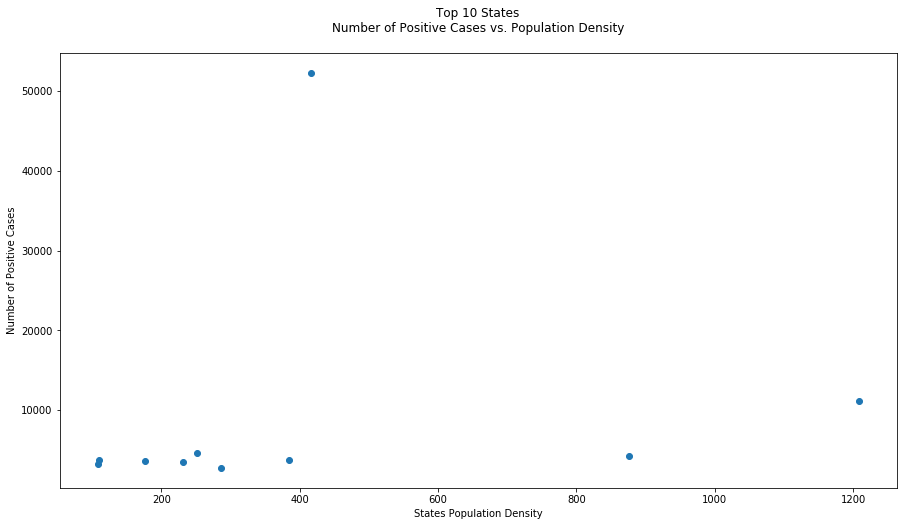

In [25]:
top10_states_positive
top10_states_density = states_completed_data.loc[[0,1,2,3,4,5,6,7,8,9],["state population density"]]["state population density"]

correlation = st.pearsonr(top10_states_positive, top10_states_density)
print(f"The correlation between both factors is {round(correlation[0],5)}")

plt.figure(figsize = (15,8))
plt.scatter(top10_states_density, top10_states_positive)

plt.xlabel("States Population Density")
plt.ylabel("Number of Positive Cases")
plt.title("""Top 10 States
Number of Positive Cases vs. Population Density
         """)

plt.savefig("Output_Figures/top10_states_pos_density.png")
plt.show()

The correlation between both factors is 0.00358


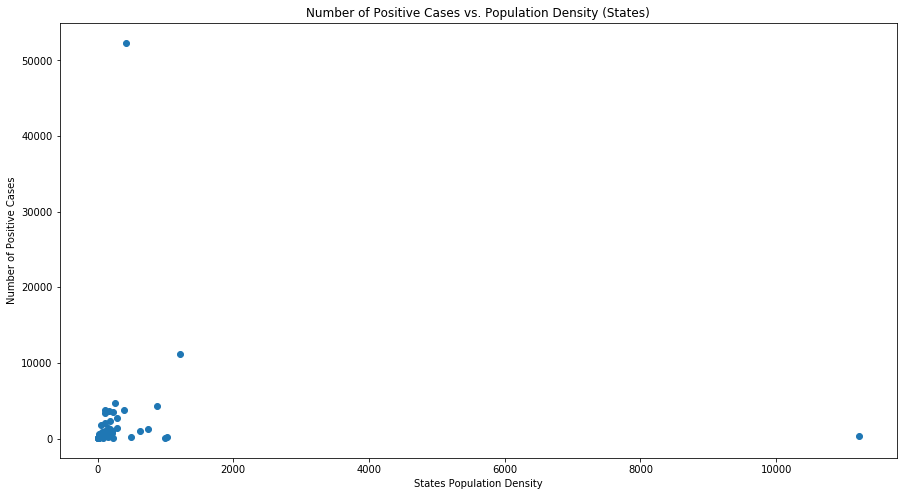

In [26]:
states_positive = states_completed_data["positive"]
states_density = states_completed_data["state population density"]

correlation = st.pearsonr(states_positive, states_density)
print(f"The correlation between both factors is {round(correlation[0],5)}")

plt.figure(figsize = (15,8))
plt.scatter(states_density, states_positive)

plt.xlabel("States Population Density")
plt.ylabel("Number of Positive Cases")
plt.title("Number of Positive Cases vs. Population Density (States)")

plt.savefig("Output_Figures/states_pos_density.png")
plt.show()

In [27]:
# Obtain county covid-19 data as of 3/28 and merge with county geo data
counties_328data = counties_data.loc[counties_data["date"] == "2020-03-28"]
counties_328data = counties_328data.sort_values(["state","county"]).reset_index(drop = True)

counties_completed_data = pd.merge(counties_328data, county_complete, on ="county", how = "left")

counties_completed_data.head()

,date,county,state_x,fips,cases,deaths,state_y,county population(2018),county land area(sq mi),county population density
0,2020-03-28,Autauga,Alabama,1001.0,6,0,NaN,NaN,NaN,NaN
1,2020-03-28,Baldwin,Alabama,1003.0,10,0,NaN,NaN,NaN,NaN
2,2020-03-28,Blount,Alabama,1009.0,5,0,NaN,NaN,NaN,NaN
3,2020-03-28,Bullock,Alabama,1011.0,3,0,NaN,NaN,NaN,NaN
4,2020-03-28,Butler,Alabama,1013.0,1,0,NaN,NaN,NaN,NaN


In [28]:
county_complete["county"] = county_complete.county.str.split(" ",[0])

In [29]:
county_complete

,state,county,county population(2018),county land area(sq mi),county population density
0,Alabama,NaN,55200.0,594.44,92.860507
1,Alabama,NaN,208107.0,1589.78,130.903018
2,Alabama,NaN,208107.0,257.84,807.116817
3,Georgia,NaN,45286.0,1589.78,28.485702
4,Georgia,NaN,45286.0,257.84,175.636053
...,...,...,...,...,...
14587,Wyoming,NaN,9951.0,4886.54,2.036410
14588,Wyoming,NaN,44117.0,10426.65,4.231177
14589,Wyoming,NaN,20609.0,2081.26,9.902175
14590,Wyoming,NaN,8129.0,2238.55,3.631369


# Timing Analysis

# Hot Spots Analysis

In [30]:
# Obtain states data dataframe as of 3-28, the cutoff date.
states_data_clean
# Format date column
states_data_clean['date'] = pd.to_datetime(states_data_clean['date'].astype(str), format='%Y%m%d')
states_data_clean

,date,state code,positive,negative,pending,hospitalized,death,total,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,state
0,2020-03-28,AK,85.0,2836.0,0.0,5.0,2.0,2921,2921,1.0,2.0,517.0,16.0,533.0,Alaska
1,2020-03-28,AL,696.0,4184.0,0.0,0.0,3.0,4880,4880,0.0,0.0,0.0,109.0,109.0,Alabama
2,2020-03-28,AR,404.0,2938.0,0.0,48.0,5.0,3342,3342,2.0,0.0,1393.0,23.0,1416.0,Arkansas
3,2020-03-28,AS,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,American Samoa
4,2020-03-28,AZ,873.0,7455.0,21.0,0.0,15.0,8349,8328,2.0,0.0,0.0,137.0,137.0,Arizona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2020-03-04,OR,3.0,29.0,18.0,0.0,0.0,50,32,0.0,0.0,0.0,0.0,0.0,Oregon
1257,2020-03-04,SC,0.0,5.0,0.0,0.0,0.0,5,5,0.0,0.0,0.0,0.0,0.0,South Carolina
1258,2020-03-04,TX,1.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,Texas
1259,2020-03-04,WA,39.0,0.0,0.0,0.0,0.0,39,39,0.0,0.0,0.0,0.0,0.0,Washington


In [31]:
# Generate line graph showing confirmed cases for top 6 states over time

In [32]:
# Drop unneeded columns from states_data_clean
states_confirmed_cases_date_df = states_data_clean.drop(columns = ["negative",
                                                                  "pending",
                                                                  "hospitalized",
                                                                  "death",
                                                                  "total",
                                                                  "totalTestResults",
                                                                  "deathIncrease",
                                                                  "hospitalizedIncrease",
                                                                  "negativeIncrease",
                                                                  "positiveIncrease",
                                                                  "totalTestResultsIncrease",
                                                                  "state"])
states_confirmed_cases_date_df

,date,state code,positive
0,2020-03-28,AK,85.0
1,2020-03-28,AL,696.0
2,2020-03-28,AR,404.0
3,2020-03-28,AS,0.0
4,2020-03-28,AZ,873.0
...,...,...,...
1256,2020-03-04,OR,3.0
1257,2020-03-04,SC,0.0
1258,2020-03-04,TX,1.0
1259,2020-03-04,WA,39.0


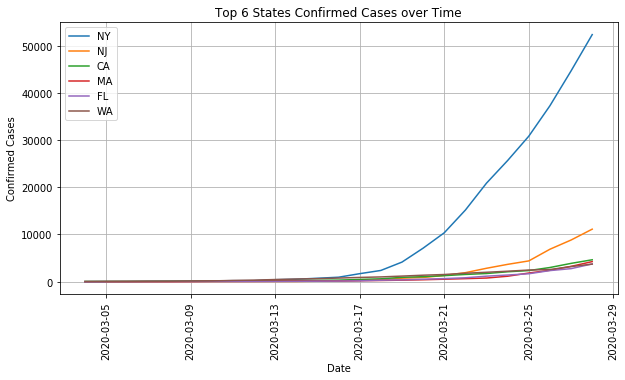

NameError: name 'warnings' is not defined

In [47]:
# Create dataframe containing only top6 states data: NY, NJ, CA, MA, FL, WA
NY = states_confirmed_cases_date_df.loc[states_confirmed_cases_date_df['state code']=='NY']
NJ = states_confirmed_cases_date_df.loc[states_confirmed_cases_date_df['state code']=='NJ']
CA = states_confirmed_cases_date_df.loc[states_confirmed_cases_date_df['state code']=='CA']
MA = states_confirmed_cases_date_df.loc[states_confirmed_cases_date_df['state code']=='MA']
FL = states_confirmed_cases_date_df.loc[states_confirmed_cases_date_df['state code']=='FL']
WA = states_confirmed_cases_date_df.loc[states_confirmed_cases_date_df['state code']=='WA']

plt.figure(figsize = (10, 5))

plt.plot(NY['date'],NY['positive'], label="NY")
plt.plot(NJ['date'],NJ['positive'], label="NJ")
plt.plot(CA['date'],CA['positive'], label="CA")
plt.plot(MA['date'],MA['positive'], label="MA")
plt.plot(FL['date'],FL['positive'], label="FL")
plt.plot(WA['date'],WA['positive'], label="WA")

plt.ylabel("Confirmed Cases")
plt.xlabel('Date')
plt.title('Top 6 States Confirmed Cases over Time')
plt.grid()
plt.legend(loc="upper left")
plt.xticks(rotation=90)
plt.savefig("Output_Figures/hotspots_top6_confirmed_cases_over_time.png")

plt.show()
warnings.filterwarnings('ignore')

In [34]:
# Generate line graph showing deaths for top 6 states over time

In [35]:
# Drop unneeded columns from states_data_clean
states_deaths_date_df = states_data_clean.drop(columns = ["positive",
                                                                  "negative",
                                                                  "pending",
                                                                  "hospitalized",
                                                                  "total",
                                                                  "totalTestResults",
                                                                  "deathIncrease",
                                                                  "hospitalizedIncrease",
                                                                  "negativeIncrease",
                                                                  "positiveIncrease",
                                                                  "totalTestResultsIncrease",
                                                                  "state"])
states_deaths_date_df

,date,state code,death
0,2020-03-28,AK,2.0
1,2020-03-28,AL,3.0
2,2020-03-28,AR,5.0
3,2020-03-28,AS,0.0
4,2020-03-28,AZ,15.0
...,...,...,...
1256,2020-03-04,OR,0.0
1257,2020-03-04,SC,0.0
1258,2020-03-04,TX,0.0
1259,2020-03-04,WA,0.0


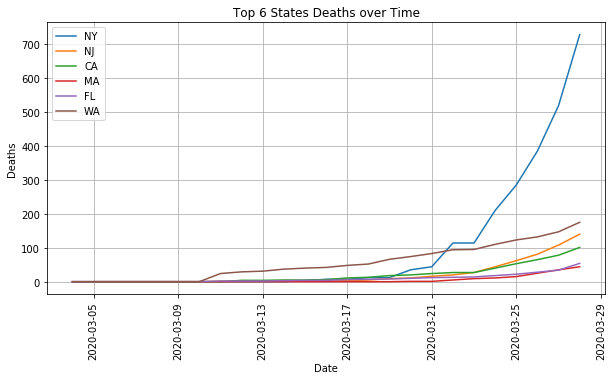

In [36]:
# Create dataframe containing only top6 states data: NY, NJ, CA, MA, FL, WA
NY = states_deaths_date_df.loc[states_deaths_date_df['state code']=='NY']
NJ = states_deaths_date_df.loc[states_deaths_date_df['state code']=='NJ']
CA = states_deaths_date_df.loc[states_deaths_date_df['state code']=='CA']
MA = states_deaths_date_df.loc[states_deaths_date_df['state code']=='MA']
FL = states_deaths_date_df.loc[states_deaths_date_df['state code']=='FL']
WA = states_deaths_date_df.loc[states_deaths_date_df['state code']=='WA']

plt.figure(figsize = (10, 5))

plt.plot(NY['date'],NY['death'], label="NY")
plt.plot(NJ['date'],NJ['death'], label="NJ")
plt.plot(CA['date'],CA['death'], label="CA")
plt.plot(MA['date'],MA['death'], label="MA")
plt.plot(FL['date'],FL['death'], label="FL")
plt.plot(WA['date'],WA['death'], label="WA")

plt.ylabel("Deaths")
plt.xlabel('Date')
plt.title('Top 6 States Deaths over Time')
plt.grid()
plt.legend(loc="upper left")
plt.xticks(rotation=90)
plt.savefig("Output_Figures/hotspots_top6_deaths_over_time.png")

plt.show()

In [37]:
# Generate line graph showing delta of cases confirmed over time (# cases confirmed today - #cases confirmed yesterday) 
# for top 6 states over time

In [38]:
# Drop unneeded columns from states_data_clean
states_confirmed_cases_date_df = states_data_clean.drop(columns = ["negative",
                                                                  "pending",
                                                                  "hospitalized",
                                                                  "death",
                                                                  "total",
                                                                  "totalTestResults",
                                                                  "deathIncrease",
                                                                  "hospitalizedIncrease",
                                                                  "negativeIncrease",
                                                                  "positiveIncrease",
                                                                  "totalTestResultsIncrease",
                                                                  "state"])
states_confirmed_cases_date_df

,date,state code,positive
0,2020-03-28,AK,85.0
1,2020-03-28,AL,696.0
2,2020-03-28,AR,404.0
3,2020-03-28,AS,0.0
4,2020-03-28,AZ,873.0
...,...,...,...
1256,2020-03-04,OR,3.0
1257,2020-03-04,SC,0.0
1258,2020-03-04,TX,1.0
1259,2020-03-04,WA,39.0


In [39]:
# Sort states_confirmed_cases_date_df so that the dates are listed in reverse order (oldest to newest)
states_confirmed_cases_date_df.sort_values(['date'], inplace=True)
states_confirmed_cases_date_df

,date,state code,positive
1260,2020-03-04,WI,1.0
1247,2020-03-04,AZ,2.0
1248,2020-03-04,CA,53.0
1249,2020-03-04,FL,2.0
1250,2020-03-04,GA,2.0
...,...,...,...
32,2020-03-28,NE,96.0
31,2020-03-28,ND,83.0
30,2020-03-28,NC,935.0
28,2020-03-28,MS,663.0


In [40]:
# Create dataframe containing only top6 states data: NY, NJ, CA, MA, FL, WA
NY = states_confirmed_cases_date_df.loc[states_confirmed_cases_date_df['state code']=='NY']
NJ = states_confirmed_cases_date_df.loc[states_confirmed_cases_date_df['state code']=='NJ']
CA = states_confirmed_cases_date_df.loc[states_confirmed_cases_date_df['state code']=='CA']
MA = states_confirmed_cases_date_df.loc[states_confirmed_cases_date_df['state code']=='MA']
FL = states_confirmed_cases_date_df.loc[states_confirmed_cases_date_df['state code']=='FL']
WA = states_confirmed_cases_date_df.loc[states_confirmed_cases_date_df['state code']=='WA']

In [41]:
NY_delta = NY.copy()
NJ_delta = NJ.copy()
CA_delta = CA.copy()
MA_delta = MA.copy()
FL_delta = FL.copy()
WA_delta = WA.copy()

In [42]:
# Group by client and calculate deltas for each group
NY_delta['deltas'] = NY_delta.positive.diff().shift(-1)
NJ_delta['deltas'] = NJ_delta.positive.diff().shift(-1)
CA_delta['deltas'] = CA_delta.positive.diff().shift(-1)
MA_delta['deltas'] = MA_delta.positive.diff().shift(-1)
FL_delta['deltas'] = FL_delta.positive.diff().shift(-1)
WA_delta['deltas'] = WA_delta.positive.diff().shift(-1)

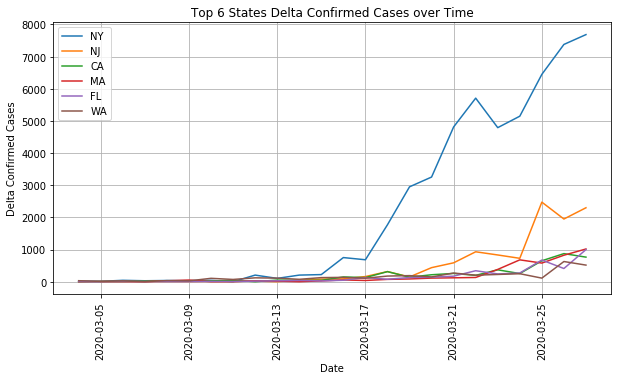

In [43]:
plt.figure(figsize = (10, 5))

plt.plot(NY_delta['date'],NY_delta['deltas'], label="NY")
plt.plot(NJ_delta['date'],NJ_delta['deltas'], label="NJ")
plt.plot(CA_delta['date'],CA_delta['deltas'], label="CA")
plt.plot(MA_delta['date'],MA_delta['deltas'], label="MA")
plt.plot(FL_delta['date'],FL_delta['deltas'], label="FL")
plt.plot(WA_delta['date'],WA_delta['deltas'], label="WA")

plt.ylabel("Delta Confirmed Cases")
plt.xlabel('Date')
plt.title('Top 6 States Delta Confirmed Cases over Time')
plt.grid()
plt.legend(loc="upper left")
plt.xticks(rotation=90)
plt.savefig("Output_Figures/hotspots_top6_delta_confirmed_cases_over_time.png")

plt.show()

In [44]:
# Generate line graph showing total tested results increase for top 6 states over time

In [45]:
# Drop unneeded columns from states_data_clean
states_total_tested_results_increase_date_df = states_data_clean.drop(columns = ["positive",
                                                                                 "negative",
                                                                                 "pending",
                                                                                 "hospitalized",
                                                                                 "death",
                                                                                 "total",
                                                                                 "totalTestResults",
                                                                                 "deathIncrease",
                                                                                 "hospitalizedIncrease",
                                                                                 "negativeIncrease",
                                                                                 "positiveIncrease",
                                                                                 "state"])
states_total_tested_results_increase_date_df

,date,state code,totalTestResultsIncrease
0,2020-03-28,AK,533.0
1,2020-03-28,AL,109.0
2,2020-03-28,AR,1416.0
3,2020-03-28,AS,0.0
4,2020-03-28,AZ,137.0
...,...,...,...
1256,2020-03-04,OR,0.0
1257,2020-03-04,SC,0.0
1258,2020-03-04,TX,0.0
1259,2020-03-04,WA,0.0


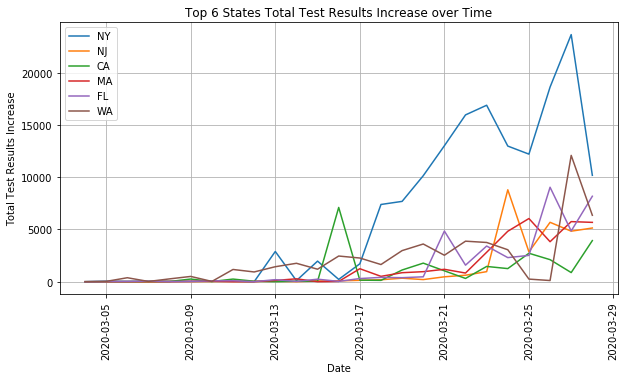

In [46]:
# Create dataframe containing only top6 states data: NY, NJ, CA, MA, FL, WA
NY = states_total_tested_results_increase_date_df.loc[states_total_tested_results_increase_date_df['state code']=='NY']
NJ = states_total_tested_results_increase_date_df.loc[states_total_tested_results_increase_date_df['state code']=='NJ']
CA = states_total_tested_results_increase_date_df.loc[states_total_tested_results_increase_date_df['state code']=='CA']
MA = states_total_tested_results_increase_date_df.loc[states_total_tested_results_increase_date_df['state code']=='MA']
FL = states_total_tested_results_increase_date_df.loc[states_total_tested_results_increase_date_df['state code']=='FL']
WA = states_total_tested_results_increase_date_df.loc[states_total_tested_results_increase_date_df['state code']=='WA']

plt.figure(figsize = (10, 5))

plt.plot(NY['date'],NY['totalTestResultsIncrease'], label="NY")
plt.plot(NJ['date'],NJ['totalTestResultsIncrease'], label="NJ")
plt.plot(CA['date'],CA['totalTestResultsIncrease'], label="CA")
plt.plot(MA['date'],MA['totalTestResultsIncrease'], label="MA")
plt.plot(FL['date'],FL['totalTestResultsIncrease'], label="FL")
plt.plot(WA['date'],WA['totalTestResultsIncrease'], label="WA")

plt.ylabel("Total Test Results Increase")
plt.xlabel('Date')
plt.title('Top 6 States Total Test Results Increase over Time')
plt.grid()
plt.legend(loc="upper left")
plt.xticks(rotation=90)
plt.savefig("Output_Figures/hotspots_top6_total_test_results_increase_over_time.png")

plt.show()